In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Load Data

Fashion MNIST Dataset

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 8261415.02it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 137537.34it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 2594983.97it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 7185449.91it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [6]:
help(test_data)

Help on FashionMNIST in module torchvision.datasets.mnist object:

class FashionMNIST(MNIST)
 |  FashionMNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where ``FashionMNIST/raw/train-images-idx3-ubyte``
 |          and  ``FashionMNIST/raw/t10k-images-idx3-ubyte`` exist.
 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 |          otherwise from ``t10k-images-idx3-ubyte``.
 |      download (bool, optional): If True, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 |          and returns a transformed v

In [15]:
num_classes = len(training_data.classes)
print(f"There are {num_classes} classes in training data")

There are 10 classes in training data


# Model 1

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [26]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=num_outputs)
        )

    def forward(self, x):
        return self.net(x)

In [27]:
model = NeuralNetwork(num_classes).to(device)
print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


# Training

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [29]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [31]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.316381  [   64/60000]
loss: 2.134012  [ 6464/60000]
loss: 1.901960  [12864/60000]
loss: 1.851697  [19264/60000]
loss: 1.657638  [25664/60000]
loss: 1.571808  [32064/60000]
loss: 1.538441  [38464/60000]
loss: 1.449284  [44864/60000]
loss: 1.454130  [51264/60000]
loss: 1.331357  [57664/60000]
Test Error: 
 Accuracy: 65.6%, Avg loss: 1.348110 

Epoch 2
-------------------------------
loss: 1.394924  [   64/60000]
loss: 1.397490  [ 6464/60000]
loss: 1.198181  [12864/60000]
loss: 1.321462  [19264/60000]
loss: 1.158725  [25664/60000]
loss: 1.154078  [32064/60000]
loss: 1.178211  [38464/60000]
loss: 1.126668  [44864/60000]
loss: 1.165263  [51264/60000]
loss: 1.073242  [57664/60000]
Test Error: 
 Accuracy: 67.1%, Avg loss: 1.095738 

Epoch 3
-------------------------------
loss: 1.132401  [   64/60000]
loss: 1.178379  [ 6464/60000]
loss: 0.963545  [12864/60000]
loss: 1.143012  [19264/60000]
loss: 0.987211  [25664/60000]
loss: 0.995211  [32064/600

# Inference

In [33]:
classes = training_data.classes

In [70]:
# Remember that you must call model.eval() to set dropout and 
# batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
model.eval()

preds = []
targets = []
for X, y in iter(test_data):
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        preds.append(model(X.to(device)).argmax(axis=1).item())
        targets.append(y)

In [97]:
wrongs = [i for i, (x, y) in enumerate(zip(preds, targets)) if y != x]
corrects = [i for i, (x, y) in enumerate(zip(preds, targets)) if y == x]

# Visualization

In [98]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

transform = transforms.ToPILImage()

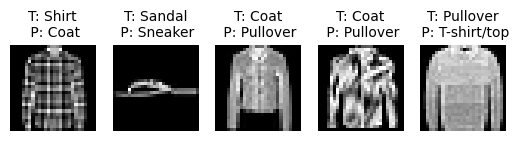

In [99]:
n_samples = 5
fig, ax = plt.subplots(1, n_samples)
for i in range(0, n_samples):
    img = transform(test_data[wrongs[i]][0])
    ax[i].set_title(f"T: {classes[targets[wrongs[i]]]}\n P: {classes[preds[wrongs[i]]]}", fontsize=10)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

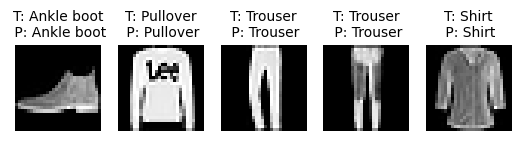

In [100]:
n_samples = 5
fig, ax = plt.subplots(1, n_samples)
for i in range(0, n_samples):
    img = transform(test_data[corrects[i]][0])
    ax[i].set_title(f"T: {classes[targets[corrects[i]]]}\n P: {classes[preds[corrects[i]]]}", fontsize=10)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

# Model 2

In [102]:
# Define model
class NeuralNetwork_2(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_outputs)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [103]:
model = NeuralNetwork_2(num_classes).to(device)
print(model)

NeuralNetwork_2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [104]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [105]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311048  [   64/60000]
loss: 2.291813  [ 6464/60000]
loss: 2.269385  [12864/60000]
loss: 2.257255  [19264/60000]
loss: 2.251544  [25664/60000]
loss: 2.220616  [32064/60000]
loss: 2.218615  [38464/60000]
loss: 2.189704  [44864/60000]
loss: 2.185480  [51264/60000]
loss: 2.141495  [57664/60000]
Test Error: 
 Accuracy: 51.7%, Avg loss: 2.144535 

Epoch 2
-------------------------------
loss: 2.160063  [   64/60000]
loss: 2.146912  [ 6464/60000]
loss: 2.085392  [12864/60000]
loss: 2.092832  [19264/60000]
loss: 2.058709  [25664/60000]
loss: 1.989423  [32064/60000]
loss: 2.003285  [38464/60000]
loss: 1.932103  [44864/60000]
loss: 1.933762  [51264/60000]
loss: 1.844371  [57664/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.857330 

Epoch 3
-------------------------------
loss: 1.896463  [   64/60000]
loss: 1.861593  [ 6464/60000]
loss: 1.745633  [12864/60000]
loss: 1.776139  [19264/60000]
loss: 1.679672  [25664/60000]
loss: 1.629313  [32064/600

# Inference

In [106]:
classes = training_data.classes

In [107]:
# Remember that you must call model.eval() to set dropout and 
# batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
model.eval()

preds = []
targets = []
for X, y in iter(test_data):
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        preds.append(model(X.to(device)).argmax(axis=1).item())
        targets.append(y)

In [108]:
wrongs = [i for i, (x, y) in enumerate(zip(preds, targets)) if y != x]
corrects = [i for i, (x, y) in enumerate(zip(preds, targets)) if y == x]

# Visualization

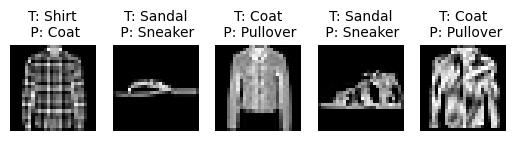

In [109]:
n_samples = 5
fig, ax = plt.subplots(1, n_samples)
for i in range(0, n_samples):
    img = transform(test_data[wrongs[i]][0])
    ax[i].set_title(f"T: {classes[targets[wrongs[i]]]}\n P: {classes[preds[wrongs[i]]]}", fontsize=10)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')